<a href="https://colab.research.google.com/github/b-fatma/S2I-DM/blob/master/src/3_merge/v2/merge_4_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import pandas as pd
import csv
import sys
import geopandas as gpd
import shapely
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
input_path = '/content/drive/MyDrive/dm_fire_prediction/mergee/fire_landcover_elevation_no_binning_soil_no_na_climate.csv'

df = pd.read_csv(input_path)
df.head()

,longitude,latitude,fire,GRIDCODE,elevation,latitude_soil,longitude_soil,COARSE,SAND,SILT,...,prec_summer,prec_winter,tmax_autumn,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter
0,5.53337,35.70751,1,134.0,1898.0,35.707501,5.530728,13.5,41.0,34.5,...,19.68,115.02,19.42,17.17,29.67,8.83,10.00,6.50,16.25,1.25
1,6.46961,32.13579,1,202.0,137.0,32.139236,6.472775,9.0,55.0,30.0,...,2.30,9.48,32.25,31.67,43.67,19.75,19.33,16.92,28.67,6.67
2,6.97630,32.35563,1,202.0,125.0,32.347663,6.997986,12.0,57.0,27.0,...,2.20,10.42,32.00,31.33,43.33,19.67,19.25,16.67,28.33,6.50
3,9.39581,28.19791,1,201.0,616.0,28.195803,9.398955,12.0,57.0,27.0,...,1.00,8.95,31.67,31.50,41.33,19.92,16.67,15.08,25.00,4.08
4,9.49323,28.12826,1,201.0,589.0,28.129107,9.490658,12.0,57.0,27.0,...,1.00,8.20,31.67,31.67,41.33,20.00,17.00,15.67,25.50,5.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column          Dtype  
---  ------          -----  
 0   longitude       float64
 1   latitude        float64
 2   fire            int64  
 3   GRIDCODE        float64
 4   elevation       float64
 5   latitude_soil   float64
 6   longitude_soil  float64
 7   COARSE          float64
 8   SAND            float64
 9   SILT            float64
 10  CLAY            float64
 11  BULK            float64
 12  REF_BULK        float64
 13  ORG_CARBON      float64
 14  PH_WATER        float64
 15  TOTAL_N         float64
 16  CN_RATIO        float64
 17  CEC_SOIL        float64
 18  CEC_CLAY        float64
 19  CEC_EFF         float64
 20  TEB             float64
 21  BSAT            float64
 22  ALUM_SAT        float64
 23  ESP             float64
 24  TCARBON_EQ      float64
 25  GYPSUM          float64
 26  ELEC_COND       float64
 27  TEXTURE_USDA    float64
 28  TEXTURE_SOTE

## Fill Missing Landcover Values

In [5]:
df.isna().sum()

,0
longitude,0
latitude,0
fire,0
GRIDCODE,931
elevation,0
latitude_soil,0
longitude_soil,0
COARSE,0
SAND,0
SILT,0


In [6]:
from sklearn.neighbors import BallTree
import numpy as np

def fill_missing_gridcode(df):
    missing_lcc_df = df[df['GRIDCODE'].isna()]
    non_missing_lcc_df = df[~df['GRIDCODE'].isna()]

    if non_missing_lcc_df.empty:
        return df

    # Prepare data for BallTree
    # Ensure coordinates are numerical before passing to BallTree
    non_missing_coords = non_missing_lcc_df[['longitude', 'latitude']].to_numpy().astype(float)
    non_missing_lcc_values = non_missing_lcc_df['GRIDCODE'].values

    # Create a BallTree
    tree = BallTree(np.radians(non_missing_coords), metric='haversine')

    for index, row in missing_lcc_df.iterrows():
        # Ensure query point coordinates are numerical
        query_point = np.radians(row[['longitude', 'latitude']].to_numpy().astype(float).reshape(1, -1))

        # Query the BallTree for the nearest neighbor
        distance, ind = tree.query(query_point, k=1)

        nearest_lcccode = non_missing_lcc_values[ind[0][0]]

        df.loc[index, 'GRIDCODE'] = nearest_lcccode
    return df

In [7]:
df = fill_missing_gridcode(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column          Dtype  
---  ------          -----  
 0   longitude       float64
 1   latitude        float64
 2   fire            int64  
 3   GRIDCODE        float64
 4   elevation       float64
 5   latitude_soil   float64
 6   longitude_soil  float64
 7   COARSE          float64
 8   SAND            float64
 9   SILT            float64
 10  CLAY            float64
 11  BULK            float64
 12  REF_BULK        float64
 13  ORG_CARBON      float64
 14  PH_WATER        float64
 15  TOTAL_N         float64
 16  CN_RATIO        float64
 17  CEC_SOIL        float64
 18  CEC_CLAY        float64
 19  CEC_EFF         float64
 20  TEB             float64
 21  BSAT            float64
 22  ALUM_SAT        float64
 23  ESP             float64
 24  TCARBON_EQ      float64
 25  GYPSUM          float64
 26  ELEC_COND       float64
 27  TEXTURE_USDA    float64
 28  TEXTURE_SOTE

## Drop Unnecessary Columns

In [8]:
df.drop(columns=['longitude_soil', 'latitude_soil'], inplace=True)

## Converting to Appropriate Types

In [9]:
# df[[c for c in df.columns if c.startswith('TEXTURE_SOTER')]] = df[[c for c in df.columns if c.startswith('TEXTURE_SOTER')]].astype('int64')
# df.info()

In [10]:
output_path = '/content/drive/MyDrive/dm_fire_prediction/mergee/merged.csv'
df.to_csv(output_path, index=False)

In [11]:
# df.info()

In [12]:
df['fire'].sum()

np.int64(12743)

## Drop Lon Lat

In [13]:
df_test = df.drop(columns=['longitude', 'latitude'])
df_test.drop_duplicates(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1119951 entries, 0 to 1965256
Data columns (total 37 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   fire           1119951 non-null  int64  
 1   GRIDCODE       1119951 non-null  float64
 2   elevation      1119951 non-null  float64
 3   COARSE         1119951 non-null  float64
 4   SAND           1119951 non-null  float64
 5   SILT           1119951 non-null  float64
 6   CLAY           1119951 non-null  float64
 7   BULK           1119951 non-null  float64
 8   REF_BULK       1119951 non-null  float64
 9   ORG_CARBON     1119951 non-null  float64
 10  PH_WATER       1119951 non-null  float64
 11  TOTAL_N        1119951 non-null  float64
 12  CN_RATIO       1119951 non-null  float64
 13  CEC_SOIL       1119951 non-null  float64
 14  CEC_CLAY       1119951 non-null  float64
 15  CEC_EFF        1119951 non-null  float64
 16  TEB            1119951 non-null  float64
 17  BSAT         

In [14]:
df_test['fire'].sum()

np.int64(3984)

In [15]:
df_test['fire'].sum() / df_test.shape[0] * 100

np.float64(0.3557298488951749)

In [16]:
df_test.head()

,fire,GRIDCODE,elevation,COARSE,SAND,SILT,CLAY,BULK,REF_BULK,ORG_CARBON,...,prec_summer,prec_winter,tmax_autumn,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter
0,1,134.0,1898.0,13.5,41.0,34.5,24.5,1.425,1.775,2.1635,...,19.68,115.02,19.42,17.17,29.67,8.83,10.00,6.50,16.25,1.25
1,1,202.0,137.0,9.0,55.0,30.0,15.0,1.420,1.620,0.5890,...,2.30,9.48,32.25,31.67,43.67,19.75,19.33,16.92,28.67,6.67
2,1,202.0,125.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,2.20,10.42,32.00,31.33,43.33,19.67,19.25,16.67,28.33,6.50
3,1,201.0,616.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,1.00,8.95,31.67,31.50,41.33,19.92,16.67,15.08,25.00,4.08
4,1,201.0,589.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,1.00,8.20,31.67,31.67,41.33,20.00,17.00,15.67,25.50,5.00


In [17]:
output_path2 = '/content/drive/MyDrive/dm_fire_prediction/mergee/merged_no_duplicates.csv'
df_test.to_csv(output_path2, index=False)

## Playing Around with imbalance-learn

In [18]:
input_path = '/content/drive/MyDrive/dm_fire_prediction/mergee/merged.csv'
df = pd.read_csv(input_path)
df.head()

,longitude,latitude,fire,GRIDCODE,elevation,COARSE,SAND,SILT,CLAY,BULK,...,prec_summer,prec_winter,tmax_autumn,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter
0,5.53337,35.70751,1,134.0,1898.0,13.5,41.0,34.5,24.5,1.425,...,19.68,115.02,19.42,17.17,29.67,8.83,10.00,6.50,16.25,1.25
1,6.46961,32.13579,1,202.0,137.0,9.0,55.0,30.0,15.0,1.420,...,2.30,9.48,32.25,31.67,43.67,19.75,19.33,16.92,28.67,6.67
2,6.97630,32.35563,1,202.0,125.0,12.0,57.0,27.0,16.0,1.430,...,2.20,10.42,32.00,31.33,43.33,19.67,19.25,16.67,28.33,6.50
3,9.39581,28.19791,1,201.0,616.0,12.0,57.0,27.0,16.0,1.430,...,1.00,8.95,31.67,31.50,41.33,19.92,16.67,15.08,25.00,4.08
4,9.49323,28.12826,1,201.0,589.0,12.0,57.0,27.0,16.0,1.430,...,1.00,8.20,31.67,31.67,41.33,20.00,17.00,15.67,25.50,5.00


In [19]:
!pip install imblearn

In [20]:
X = df.drop(columns=['fire'])
y = df['fire']

In [21]:
X.shape, y.shape, y.sum()

((1965257, 38), (1965257,), np.int64(12743))

## Undersampling Non Fire Instances

### Random Under Sampler

((55219, 38), (55219,), np.float64(23.077201687824843))

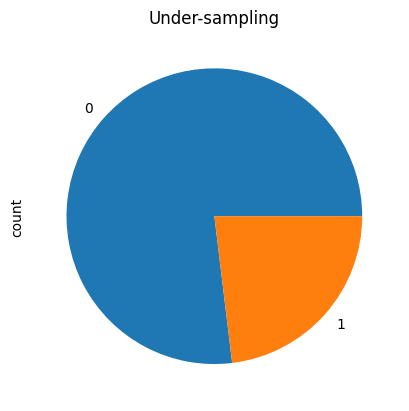

In [22]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 0.3
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
ax = y_res.value_counts().plot.pie()
_ = ax.set_title("Under-sampling")
X_res.shape, y_res.shape, y_res.sum() / y_res.shape[0] * 100

In [23]:
output_path3 = '/content/drive/MyDrive/dm_fire_prediction/mergee/merged_undersampled_23_77.csv'
df = pd.concat([X_res, y_res], axis=1)
df.to_csv(output_path3, index=False)

In [24]:
df.describe()

,longitude,latitude,GRIDCODE,elevation,COARSE,SAND,SILT,CLAY,BULK,REF_BULK,...,prec_winter,tmax_autumn,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter,fire
count,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,...,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000,55219.000000
mean,3.912609,31.679923,176.779369,453.683225,11.729273,52.222586,29.764074,18.013341,1.425464,1.670512,...,36.349146,30.388087,29.247465,40.681458,19.118076,17.215306,14.807400,25.520693,5.925410,0.230772
std,4.379150,2.784973,55.282653,305.700112,3.515412,7.898555,3.961213,4.929217,0.038190,0.068671,...,69.603096,3.674090,4.378380,4.093992,3.078117,2.500388,3.004825,3.352587,1.701082,0.421331
min,-8.118050,27.222780,14.000000,-30.000000,2.000000,15.000000,11.300000,9.200000,1.110000,1.406000,...,0.600000,17.500000,15.250000,27.670000,6.250000,7.670000,3.920000,13.170000,-1.330000,0.000000
25%,0.707898,29.221222,200.000000,209.000000,9.300000,49.600000,27.500000,15.000000,1.410000,1.620000,...,6.700000,27.670000,25.920000,37.920000,17.580000,15.920000,12.830000,23.330000,5.000000,0.000000
50%,4.867097,31.400202,201.000000,407.000000,12.000000,55.000000,28.000000,16.100000,1.430000,1.650000,...,9.950000,31.670000,31.080000,42.330000,20.000000,18.000000,15.750000,26.670000,6.080000,0.000000
75%,7.211700,33.948082,202.000000,599.000000,15.000000,57.500000,32.000000,17.400000,1.446000,1.668000,...,29.500000,33.170000,32.500000,43.920000,21.080000,19.250000,17.000000,28.170000,7.000000,0.000000
max,11.110389,37.323460,210.000000,2138.000000,37.600000,79.500000,45.200000,54.000000,1.760000,2.030000,...,622.400000,36.330000,35.830000,46.250000,25.330000,21.670000,19.670000,30.000000,11.000000,1.000000
